In [1]:
!pip install --upgrade pip
!pip install qiskit
!pip install qutip
!pip install pylatexenc
!pip install cirq
!pip install qbraid
!pip install qbraid_qir
!pip install ply

!git config --global pull.rebase false


In [40]:
import math
from math import asin

import numpy as np
import pandas as pd

import cirq

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import PhaseEstimation, UnitaryGate, HamiltonianGate
from qiskit.quantum_info import Operator, Statevector

from qutip import rand_unitary

from qbraid import QbraidProvider, ConversionGraph, QPROGRAM_REGISTRY, transpile
from qbraid_qir.cirq import cirq_to_qir

from typing import List, Tuple, Any

Let's first get B' and B''

In [3]:
frequency = 60 # Example of value

def radian_frequency(frequency):
    radian_frequency =  2*math.pi*frequency
    return radian_frequency
print(radian_frequency(60))

376.99111843077515


In [4]:
L_1_2  = 0.04/radian_frequency(60)
L_1_3 = 0.03/radian_frequency(60)
L_2_3 = 0.0215/radian_frequency(60)

R_1_2 = 0.02
R_1_3 = 0.01
R_2_3 = 0.0125

zetha = []

for L, R in zip([L_1_2, L_1_3, L_2_3], [R_1_2, R_1_3, R_2_3]):
    zetha.append(R + 1j*radian_frequency(60)* L)


print(zetha)

[(0.02+0.04j), (0.01+0.03j), (0.0125+0.0215j)]


In [5]:
y_vector =  []

for i in range(len(zetha)):
  y_vector.append(1/np.imag(zetha[i]))


print(y_vector)

[25.0, 33.333333333333336, 46.51162790697675]


In [6]:
def calculate_y_bus(R, L, C, n, m):
  y_bus_set = set()

In [7]:
def build_admittance_matrices(R, L, C, X_i, X_j, i, j, f, aprox = True, mode=1):
    """
    Construye Ybus, B, Bprime (B′) y Bdoubleprime (B″) a partir de una lista de items:
      ('R', i, j, R_ij)           # oh
    Parámetros:
      f: frecuencia en Hz
      n_buses: si None, se infiere del máx índice observado
      one_based: True si los índices vienen 1..N, False si 0..N-1
    Retorna:
      dict con 'Ybus', 'B', 'Bprime', 'Bdoubleprime'
    """
    #n = len(R)
    n = max(max(i),max(j))

    w = 2*np.pi*f
    if mode == 1:
      X = [L[i] * w for i in range(len(L))]
    elif mode == 2:
      X = L
    if aprox:
        Y = [1/(1j*X[i]) for i in range(len(X))]
    else:
        Y = [1/(1j*w*X[i]+R[i]) for i in range(len(R))]
    Y_matrix = np.array([[0j for _ in range(n)] for _ in range(n)])
    print(Y_matrix)
    counter = 0
    for i_index,j_index in zip(i,j):
        print(i_index, j_index)
        Y_matrix[i_index-1][j_index-1] = -Y[counter]
        Y_matrix[j_index-1][i_index-1] = -Y[counter]
        counter += 1
    for i_index in range(len(Y_matrix)):
      for j_index in range(len(Y_matrix)):
          if j_index != i_index:
            Y_matrix[i_index][i_index] -= Y_matrix[i_index][j_index]
    return Y_matrix

In [122]:
R = np.array([0.02,0.08,0.06,0.06, 0.04, 0.01, 0.08])
L = np.array([0.06, 0.24, 0.25, 0.18, 0.12, 0.03, 0.24])

Y = build_admittance_matrices(R, L, 0,0,0, np.array([1,1,1,2,2,2,3,4]), np.array([2,3,3,4,5,4,5]), 60, mode=2)
Y

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
1 2
1 3
1 3
2 4
2 5
2 4
3 5


array([[ 0.-20.66666667j, -0.+16.66666667j, -0. +4.j        ,
         0. +0.j        ,  0. +0.j        ],
       [-0.+16.66666667j,  0.-58.33333333j,  0. +0.j        ,
        -0.+33.33333333j, -0. +8.33333333j],
       [-0. +4.j        ,  0. +0.j        ,  0. -8.16666667j,
         0. +0.j        , -0. +4.16666667j],
       [ 0. +0.j        , -0.+33.33333333j,  0. +0.j        ,
         0.-33.33333333j,  0. +0.j        ],
       [ 0. +0.j        , -0. +8.33333333j, -0. +4.16666667j,
         0. +0.j        ,  0.-12.5j       ]])

In [123]:
node_type = {'S': 1,  'L': [3,4,5,6] , 'G': [2]}

In [124]:
length_L = len(node_type['L'])
length_G = len(node_type['G'])

def boolean_b_prime(node_type, i):
  if (i in node_type['L'] or i in node_type['G']) and i != node_type['S']:
    return True
  else:
    return False

def boolean_b_prime_prime(node_type, i):
  if (i in node_type['L']) and i != node_type['S']:
    return True
  else:
    return False

lengh_b_prime = length_L + length_G

B = Y.imag
B_prime = np.zeros((lengh_b_prime, lengh_b_prime))

prime_indices = [i-1 for i in range(1, len(B)+1) if boolean_b_prime(node_type, i)]

for ii, i_index in enumerate(prime_indices):
  for jj, j_index in enumerate(prime_indices):
    B_prime[ii][jj] = B[i_index][j_index]

B_prime_prime = np.zeros((length_L, length_L))

prime_prime_indices = [i-1 for i in range(1, len(B)+1) if boolean_b_prime_prime(node_type, i)]

for ii, i_index in enumerate(prime_prime_indices):
  for jj, j_index in enumerate(prime_prime_indices):
    B_prime_prime[ii][jj] = B[i_index][j_index]

# Substitua a função de normalização por:
def make_unitary_matrix(matrix):
    """Torna uma matriz unitária usando decomposição QR"""
    Q, R = np.linalg.qr(matrix)
    return Q

B_prime_unitary = make_unitary_matrix(B_prime)
B_prime_prime_unitary = make_unitary_matrix(B_prime_prime)

print("B_prime unitária:")
print(B_prime_unitary)
print("\nB_prime_prime unitária:")
print(B_prime_prime_unitary)

# Verificar se são unitárias (U†U = I)
print("\nVerificação B_prime unitária:")
print(np.allclose(B_prime_unitary.conj().T @ B_prime_unitary, np.eye(len(B_prime_unitary)), atol=1e-10))

print("\nVerificação B_prime_prime unitária:")
print(np.allclose(B_prime_prime_unitary.conj().T @ B_prime_prime_unitary, np.eye(len(B_prime_prime_unitary)), atol=1e-10))
print('b_prima',B_prime)
print('b_prima_prima',B_prime_prime)

B_prime unitária:
[[-0.86164044  0.048277   -0.4246153   0.27376438  0.        ]
 [ 0.         -0.89215894  0.1687267   0.41902711  0.        ]
 [ 0.49236596 -0.02758686 -0.82575286  0.27376438  0.        ]
 [ 0.12309149  0.44828642  0.33070434  0.82129313  0.        ]
 [ 0.          0.          0.         -0.          1.        ]]

B_prime_prime unitária:
[[-0.89076187  0.          0.45447034  0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.45447034  0.          0.89076187  0.        ]
 [ 0.         -0.         -0.          1.        ]]

Verificação B_prime unitária:
True

Verificação B_prime_prime unitária:
True
b_prima [[-58.33333333   0.          33.33333333   8.33333333   0.        ]
 [  0.          -8.16666667   0.           4.16666667   0.        ]
 [ 33.33333333   0.         -33.33333333   0.           0.        ]
 [  8.33333333   4.16666667   0.         -12.5          0.        ]
 [  0.           0.           0.           0.           0.        ]]
b_prima_p

In [125]:
def power_flow_mismatch(Ybus, V, theta, P_spec, Q_spec):
    """
    Calcula ΔP y ΔQ en un sistema de potencia.

    Parámetros:
        Ybus   : matriz admitancia nodal (np.array complex, nxn)
        V      : vector de magnitudes de tensión [pu] (1D, n)
        theta  : vector de ángulos [rad] (1D, n)
        P_spec : vector P especificada (gen - carga) [pu] (1D, n)
        Q_spec : vector Q especificada (gen - carga) [pu] (1D, n)

    Retorna:
        dP, dQ : vectores de desbalance ΔP, ΔQ
        P_calc, Q_calc : potencias calculadas
    """
    n = len(V)
    P_calc = np.zeros(n)
    Q_calc = np.zeros(n)

    for i in range(n):
        for j in range(n):
            G, B = Ybus[i, j].real, Ybus[i, j].imag
            angle = theta[i] - theta[j]
            P_calc[i] += V[i] * V[j] * (G*np.cos(angle) + B*np.sin(angle))
            Q_calc[i] += V[i] * V[j] * (G*np.sin(angle) - B*np.cos(angle))

    dP = P_spec - P_calc
    dQ = Q_spec - Q_calc
    return dP, dQ, P_calc, Q_calc


V = np.array([1.06, 1.0, 1.0, 1.0, 1.0])
P_spec = np.array([0, 20, -45, -40, -60])
Q_spec = np.array([0, 0, 0, 0, 0])
theta = np.array([0,30-10,-15,-5,-10])





# Calcular mismatches
dP, dQ, P_calc, Q_calc = power_flow_mismatch(Y, V, theta, P_spec, Q_spec)

print("P calculada:", P_calc)
print("Q calculada:", Q_calc)
print("ΔP:", dP)
print("ΔQ:", dQ)



P calculada: [-13.37147899   3.48337756   1.23829737   4.411725     4.23807906]
Q calculada: [19.23269366 16.7983611  10.20581764  0.2932396  10.03264548]
ΔP: [ 13.37147899  16.51662244 -46.23829737 -44.411725   -64.23807906]
ΔQ: [-19.23269366 -16.7983611  -10.20581764  -0.2932396  -10.03264548]


In [126]:
import numpy as np

def next_power_of_two(n):
    return 1 if n == 0 else 2**((n-1).bit_length())

def to_twos_complement_bits(x, n_bits=8, frac=2):
    scale = 1 << frac
    val = int(np.round(x * scale))
    mod = 1 << n_bits
    if val < 0:
        val = (val + mod) % mod
    bits = format(val, f'0{n_bits}b')
    return [int(b) for b in bits]

def matrix_to_statevector(mat, n_bits=8, frac=2):
    """
    Convert each row of a matrix to a Statevector-compatible 1D vector.
    Pads the vector to next power of 2.
    """
    rows, cols = mat.shape
    sv_list = []

    for i in range(rows):
        row_bits = []
        for j in range(cols):
            row_bits.extend(to_twos_complement_bits(mat[i, j], n_bits, frac))
        
        # Pad to next power of 2
        target_len = next_power_of_two(len(row_bits))
        if len(row_bits) < target_len:
            row_bits = [0]*(target_len - len(row_bits)) + row_bits
        
        # Convert bits to computational basis vector
        # Only works if the bits represent a single basis state
        index = int("".join(map(str, row_bits)), 2)
        vec = np.zeros(target_len)
        vec[index] = 1.0
        sv_list.append(vec)

    return sv_list


In [127]:
deltas = np.array([dP, dQ])
    
deltas_bin = np.array(matrix_to_binary(deltas,8,2))
print("Matriz en binario (Q7.8, 16 bits):")
print(len(deltas_bin[0].flatten()))



Matriz en binario (Q7.8, 16 bits):
40


In [37]:
def int_to_twos_complement(x, n_bits=16, frac=4):
    """
    Convierte número real x a string binario complemento a dos.
    n_bits = total de bits, frac = bits fraccionarios
    """
    val = int(round(x * (1 << frac)))
    mod = 1 << n_bits
    if val < 0:
        val = (val + mod) % mod
    return format(val, f'0{n_bits}b')

def twos_complement_to_real(bin_str, frac=4):
    """
    Convierte string binario complemento a dos a real (punto fijo).
    """
    n_bits = len(bin_str)
    val = int(bin_str, 2)
    if bin_str[0] == '1':
        val -= (1 << n_bits)
    return val / (1 << frac)

def quantize_matrix(mat, n_bits=16, frac=4):
    """
    Dada una matriz de reales:
    - Devuelve matriz binaria (complemento a dos)
    - Devuelve matriz reconstruida en real
    - Devuelve matriz de error
    """
    rows, cols = mat.shape
    bin_mat = np.empty((rows, cols), dtype=object)
    rec_mat = np.zeros((rows, cols))
    err_mat = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            b = int_to_twos_complement(mat[i, j], n_bits, frac)
            r = twos_complement_to_real(b, frac)
            bin_mat[i, j] = b
            rec_mat[i, j] = r
            err_mat[i, j] = r - mat[i, j]
    return bin_mat, rec_mat, err_mat


# ---------------- Ejemplo ----------------
M = np.array([[10.0, 9.8],
              [-65.0, -73.33]])

bin_M, rec_M, err_M = quantize_matrix(deltas, n_bits=8, frac=2)  # Q8.4

print("Matriz original:\n", deltas)
print("\nMatriz en binario:\n", bin_M)
print("\nMatriz recuperada (después de binario):\n", rec_M)
print("\nError de cuantización:\n", err_M)

Matriz original:
 [[ 11.84311641  21.4910771  -49.90914493 -44.00850547 -64.41654311]
 [-14.27980823 -18.35906761 -20.00256154  -5.37540683 -16.62918515]]

Matriz en binario:
 [['00101111' '01010110' '00111000' '01010000' '11111110']
 ['11000111' '10110111' '10110000' '11101010' '10111101']]

Matriz recuperada (después de binario):
 [[ 11.75  21.5   14.    20.    -0.5 ]
 [-14.25 -18.25 -20.    -5.5  -16.75]]

Error de cuantización:
 [[-9.31164097e-02  8.92290292e-03  6.39091449e+01  6.40085055e+01
   6.39165431e+01]
 [ 2.98082255e-02  1.09067608e-01  2.56153549e-03 -1.24593165e-01
  -1.20814845e-01]]


Ahora que ya tenemos B', B'' y los deltas, Vamos a crear el codigo a ejecutar

In [11]:
def reflected_gray(n: int) -> tuple:
    """Generate a reflected Gray code sequence of n bits starting at 1."""
    if n < 1:
        return tuple()
    
    seq = [1]
    for k in range(2, n + 1):
        seq = seq + seq[:-1] + [k]
    ret=seq+seq
    return tuple(ret)

In [12]:
def gray_code(n):
    """Generate n-bit Gray codes"""
    return n ^ (n >> 1)

def binary_vector(j, n):
    """Convert integer j to n-bit binary vector (LSB at end)"""
    return [int(b) for b in format(j, f'0{n}b')]

def theta_i(i, n_R):
    total = 0
    g_i_minus_1 = binary_vector(gray_code(i - 1), n_R)
    for j in range(1, 2**n_R):
        bin_j = binary_vector(j, n_R)
        dot_product = sum([a * b for a, b in zip(bin_j, g_i_minus_1)]) % 2
        sign = (-1) ** dot_product
        total += sign * asin(1 / j)
    return total / (2 ** n_R)


In [13]:
#getting theta y gray_sequence
def obtain_theta(reg_num:int):
    theta=[]
    for i in range(1, 2**reg_num + 1):
        theta.append(theta_i(i, reg_num))
    return theta

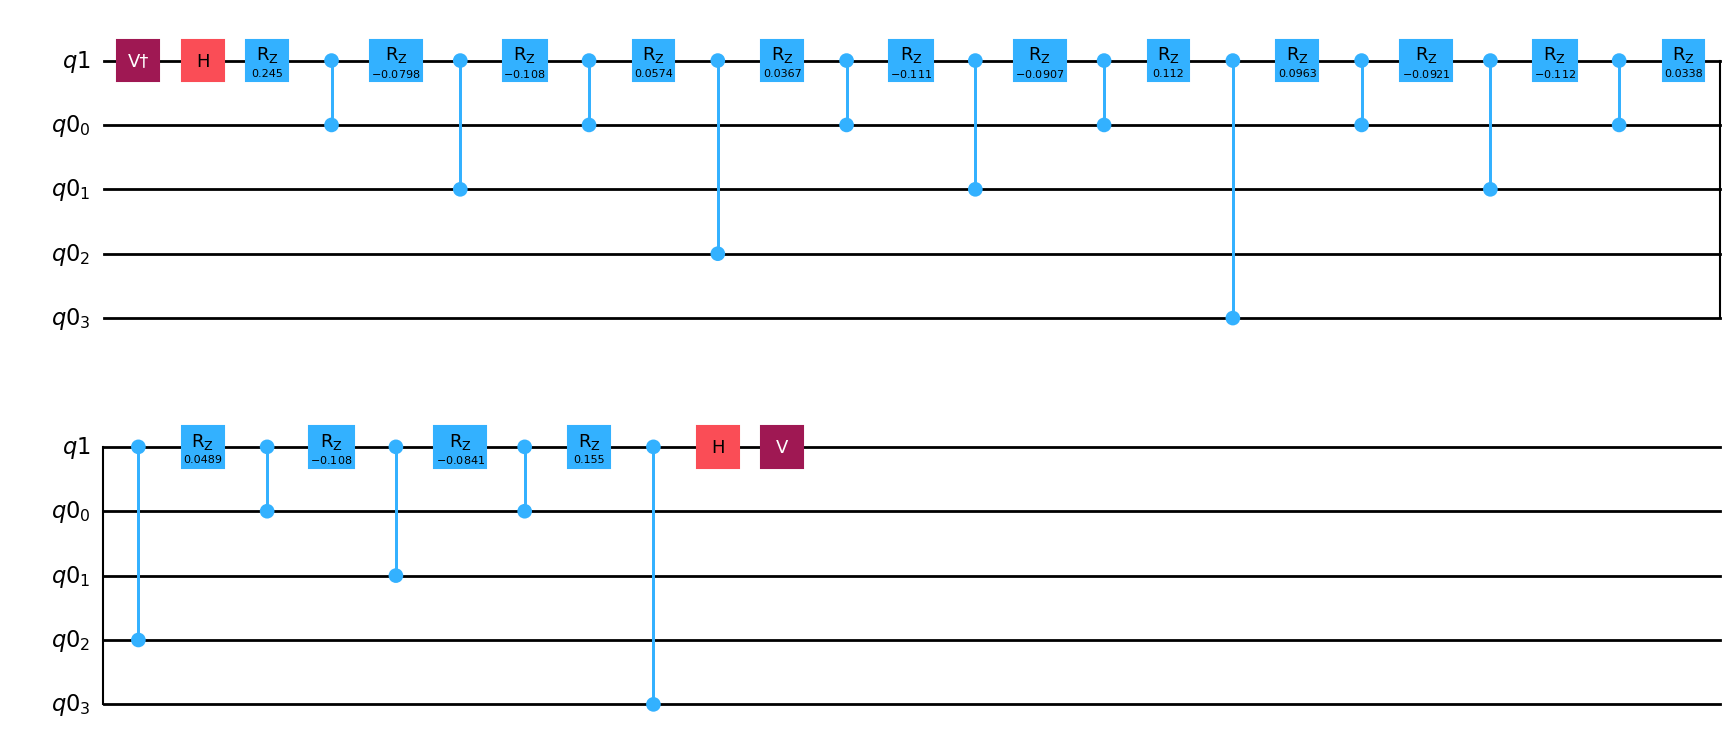

In [14]:
def AQE_opt(reg_num : int):

    #generamos qc
    qr_contr = QuantumRegister(reg_num)
    qr_target = QuantumRegister(1)

    qc = QuantumCircuit(qr_target,qr_contr)

    # Define V
    V_matrix = (1 / np.sqrt(2)) * np.array([
        [1j, -1j],  
        [1,   1]     
    ])
    
    # Now compute the conjugate transpose for V†
    V_dagger_matrix = V_matrix.conj().T
    
    # Create the unitary gates
    V_dagger_gate = UnitaryGate(V_dagger_matrix, label="V†")
    
    V_gate = UnitaryGate(V_matrix, label="V")

    #obtain aux variables
    theta=obtain_theta(reg_num)
    gray_sequence=reflected_gray(reg_num)

    #create circuit
    qc.append(V_dagger_gate, qr_target)
    qc.h(qr_target)               
    
    for idx, i in enumerate(gray_sequence):
        qc.rz(theta[idx], qr_target)   
        qc.cz(qr_contr[i-1], qr_target)
    
    qc.h(qr_target)
    qc.append(V_gate,[qr_target])

    return qc

example=AQE_opt(4)
example.draw('mpl')



In [15]:
#NO USAR
'''
def HHL_algorithm_original(unitary : UnitaryGate,
                           num_qubits_register : int,
                           ):

    # step 1) phase estimation primitive
    qpe_circuit = PhaseEstimation(num_evaluation_qubits= num_qubits_register,
                                  unitary= unitary)
    aqc_circuit = AQE_opt(num_qubits_register)
    
    # step 2) Ancilla Quantum Encoding:
    # revisar el Nielsen and Chuang si tiene dudas de esto:
    # paper adjunto tambien
    q_ancilla_reg, q_system_reg = qpe_circuit.qregs
    aqe_reg = QuantumRegister(1)
    cr = ClassicalRegister(1)

    # incializamos el circuito cuántico del HHL:
    hhl_qc = QuantumCircuit(q_ancilla_reg, q_system_reg, aqe_reg, cr)

    # le añadimos la parte del QPE:
    hhl_qc.compose(qpe_circuit, inplace=True)

    hhl_qc.barrier()

    # añadimos la parte del AQE:

    aux_list = [q_anc for q_anc in q_ancilla_reg]
    qubit_list_aqe = [num_qubits_register+len(q_system_reg)] + list(range(num_qubits_register))
    
    hhl_qc.compose(aqc_circuit, aqe_reg[:] + q_ancilla_reg[:], inplace= True)
        
    hhl_qc.barrier()

    
    # añadimos la inversa del QPE:
    hhl_qc.compose(qpe_circuit.inverse(), inplace=True)

    hhl_qc.barrier()
    #medimos:
    hhl_qc.measure(aqe_reg, cr)

    return hhl_qc
    '''

'\ndef HHL_algorithm_original(unitary : UnitaryGate,\n                           num_qubits_register : int,\n                           ):\n\n    # step 1) phase estimation primitive\n    qpe_circuit = PhaseEstimation(num_evaluation_qubits= num_qubits_register,\n                                  unitary= unitary)\n    aqc_circuit = AQE_opt(num_qubits_register)\n    \n    # step 2) Ancilla Quantum Encoding:\n    # revisar el Nielsen and Chuang si tiene dudas de esto:\n    # paper adjunto tambien\n    q_ancilla_reg, q_system_reg = qpe_circuit.qregs\n    aqe_reg = QuantumRegister(1)\n    cr = ClassicalRegister(1)\n\n    # incializamos el circuito cuántico del HHL:\n    hhl_qc = QuantumCircuit(q_ancilla_reg, q_system_reg, aqe_reg, cr)\n\n    # le añadimos la parte del QPE:\n    hhl_qc.compose(qpe_circuit, inplace=True)\n\n    hhl_qc.barrier()\n\n    # añadimos la parte del AQE:\n\n    aux_list = [q_anc for q_anc in q_ancilla_reg]\n    qubit_list_aqe = [num_qubits_register+len(q_system_reg)

In [32]:


def HHL_algorithm_original( Herm_op : np.array,
                            init_ket : np.array,
                            num_qubits_register : int):
    
    
    init_ket = init_ket.astype(float)
    init_ket /= np.linalg.norm(init_ket)
    init_ket_sv = Statevector(init_ket)


    Herm_op /= np.linalg.norm(Herm_op) #normalization

    Unitary = HamiltonianGate(Herm_op, time= 2 * np.pi) #exp^{-i 2 pi B''}
    aqc_circuit = AQE_opt(num_qubits_register)

    
    # step 1) phase estimation primitive
    qpe_circuit = PhaseEstimation(num_evaluation_qubits= num_qubits_register,
                                  unitary= Unitary)
    
    # step 2) Ancilla Quantum Encoding:
    # revisar el Nielsen and Chuang si tiene dudas de esto:
    # paper adjunto tambien
    q_ancilla_reg, q_system_reg = qpe_circuit.qregs
    aqe_reg = QuantumRegister(1)
    cr = ClassicalRegister(1)
    
    
    # incializamos el circuito cuántico del HHL:
    hhl_qc = QuantumCircuit( q_ancilla_reg, q_system_reg,aqe_reg, cr)

    hhl_qc.initialize(init_ket_sv, q_system_reg)
    
    # le añadimos la parte del QPE:
    hhl_qc.compose(qpe_circuit, inplace=True)

    hhl_qc.barrier()

    # añadimos la parte del AQE:

    hhl_qc.compose(aqc_circuit, aqe_reg[:] + q_ancilla_reg[:], inplace= True)

    hhl_qc.barrier()

    # añadimos la inversa del QPE:
    hhl_qc.compose(qpe_circuit.inverse(), inplace=True)

    hhl_qc.barrier()
    #medimos:
    hhl_qc.measure(aqe_reg, cr)

    #
    
    meas = ClassicalRegister(len(q_system_reg))
    hhl_qc.add_register(meas)

    hhl_qc.measure(q_system_reg, meas)
    
    return hhl_qc

In [17]:
'''
u_try = rand_unitary(dimensions= 2).full()
print('u_try',u_try) 
u_op = Operator(u_try).to_instruction()

print('B_prime',B_prime_prime_unitary)
Bp_op = Operator(B_prime_unitary)
Bp_op = Bp_op.to_instruction()

u_gate = HamiltonianGate(Bp_op, time = 1)


hhl_circuit = HHL_algorithm_original(unitary= u_op,
                                     num_qubits_register= 4)


hhl_circuit.draw('mpl')
'''

"\nu_try = rand_unitary(dimensions= 2).full()\nprint('u_try',u_try) \nu_op = Operator(u_try).to_instruction()\n\nprint('B_prime',B_prime_prime_unitary)\nBp_op = Operator(B_prime_unitary)\nBp_op = Bp_op.to_instruction()\n\nu_gate = HamiltonianGate(Bp_op, time = 1)\n\n\nhhl_circuit = HHL_algorithm_original(unitary= u_op,\n                                     num_qubits_register= 4)\n\n\nhhl_circuit.draw('mpl')\n"

In [18]:

def pad_to_next_power_of_two(A, tol=1e-10):
    """
    Pad a square Hermitian matrix A to the next power-of-two dimension with zeros.
    The original matrix is placed in the top-left corner of the returned matrix.

    Args:
        A (np.ndarray): square matrix (x x x), expected Hermitian.
        tol (float): tolerance for Hermitian check.

    Returns:
        np.ndarray: padded matrix of size (2^n x 2^n) with A in top-left.
    """
    # Basic checks
    if not isinstance(A, np.ndarray):
        A = np.array(A)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    x = A.shape[0]
    if x == 0:
        raise ValueError("Input matrix must have positive dimension.")

    # Hermitian check (allow small numerical errors)
    if not np.allclose(A, A.conj().T, atol=tol, rtol=0):
        raise ValueError("Input matrix is not Hermitian within tolerance.")

    # compute next power of two >= x
    # method: if x is already a power of two, target = x
    # else target = 1 << (x.bit_length())
    if (x & (x - 1)) == 0:  # x is power of two
        target = x
    else:
        target = 1 << x.bit_length()

    # create zero matrix and place A in top-left
    padded = np.zeros((target, target), dtype=A.dtype)
    padded[:x, :x] = A

    return padded

In [87]:

pad_B_prime=pad_to_next_power_of_two(B_prime)
pad_B_prime_prime=pad_to_next_power_of_two(B_prime_prime)

hhl_circuit = HHL_algorithm_original(Herm_op= pad_B_prime,
                                     init_ket= deltas_bin[0].flatten(),
                                     num_qubits_register= 4)

hhl_circuit.draw('mpl')

/tmp/ipykernel_25551/3355326984.py:18: DeprecationWarning: The class ``qiskit.circuit.library.phase_estimation.PhaseEstimation`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.phase_estimation instead.
  qpe_circuit = PhaseEstimation(num_evaluation_qubits= num_qubits_register,


QiskitError: 'Desired statevector length not a positive power of 2.'

Now we can actually sim and run on a real Quantum Computer

In [20]:
QPROGRAM_REGISTRY

{'cirq': cirq.circuits.circuit.Circuit,
 'qiskit': qiskit.circuit.quantumcircuit.QuantumCircuit,
 'openqasm3': openqasm3.ast.Program,
 'qasm2_kirin': str,
 'qasm3': str,
 'qasm2': str,
 'qubo': qbraid.programs.typer.QuboCoefficientsDict,
 'ionq': qbraid.programs.typer.IonQDict,
 'pyqir': Module}

In [21]:
# Convert to cirq so that we can use the cirq_to_qir function to get to the right format for some azure endpoints

cirq_circuit = transpile(hhl_circuit.decompose(reps=6), "cirq")

Barriers are not supported in Cirq, and will be removed during program conversion.


In [26]:
hhl_circuit.decompose(reps=6).depth()

893

In [28]:
qir_circuit = cirq_to_qir(cirq_circuit)
qasm2_circuit = transpile(cirq_circuit, "qasm2")
'''
print("QIR circuit is: \n")
print(str(qir_circuit))

print("QASM2 circuit is: \n")
print(qasm2_circuit)'''

'\nprint("QIR circuit is: \n")\nprint(str(qir_circuit))\n\nprint("QASM2 circuit is: \n")\nprint(qasm2_circuit)'

In [24]:
provider = QbraidProvider()


In [29]:

backend = provider.get_device("rigetti.sim.qvm")
job = backend.run(qir_circuit, shots=1000, entrypoint="main")


In [ ]:
backend = provider.get_device("rigetti.qpu.ankaa-3")
job = backend.run(qir_circuit, shots=1000, entrypoint="main")

In [30]:
job.status()

<INITIALIZING: 'job is being initialized'>

In [31]:
job.result()

Result(
  device_id=rigetti.sim.qvm,
  job_id=rigetti.sim.qvm-fac081022-qjob-d0mhklsqzyenf1g78n25,
  success=True,
  data=GateModelResultData(measurement_counts={'00000000': 1000}, measurements=array(shape=(0,), dtype=object), measurement_probabilities=None),
  status='COMPLETED',
  statusText='job has successfully run',
  shots=1000,
  experimentType=GATE_MODEL,
  timeStamps={createdAt: 2025-10-03T15:25:26Z, endedAt: 2025-10-03T15:25:49Z, executionDuration: 15166},
  tags={errorMitigationDebias: False},
  cost=Credits('0'),
  preflight=False,
  schemaHeader={name: 'qbraid.runtime.schemas.job', version: 1.0},
  metadata={openQasm: None, circuitNumQubits: None, circuitDepth: None}
)